In [ ]:
!pip freeze > environment.yml


In [ ]:
#!pip list | grep numpy

In [ ]:
#!pip install numpy==1.22.4

In [ ]:
%cd /content
!git clone https://github.com/srg9000/kits21_spatial_channel_attention

/content
Cloning into 'kits21_spatial_channel_attention'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 13 (delta 2), reused 4 (delta 0), pack-reused 0
Unpacking objects: 100% (13/13), 13.62 KiB | 4.54 MiB/s, done.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!rm -r '/content/content'

## Getting the data

In [ ]:
%cd /content
#!unzip '/content/drive/MyDrive/Redes neuronales/resunet_checkpoints.zip'
!unzip '/content/drive/MyDrive/Redes neuronales/try 1/checkpoints.zip'


/content
Archive:  /content/drive/MyDrive/Redes neuronales/try 1/checkpoints.zip
   creating: content/resunet_checkpoints/
  inflating: content/resunet_checkpoints/best_metric_model_7_0.1666.pth  
  inflating: content/resunet_checkpoints/best_metric_model_25_0.3284.pth  
  inflating: content/resunet_checkpoints/best_metric_model_38_0.5943.pth  
  inflating: content/resunet_checkpoints/best_metric_model_15_0.2899.pth  
  inflating: content/resunet_checkpoints/best_metric_model_19_0.5868.pth  
  inflating: content/resunet_checkpoints/best_metric_model_73_0.6292.pth  
  inflating: content/resunet_checkpoints/best_metric_model_12_0.2477.pth  
  inflating: content/resunet_checkpoints/best_metric_model_69_0.5194.pth  
  inflating: content/resunet_checkpoints/best_metric_model_24_0.3160.pth  
  inflating: content/resunet_checkpoints/best_metric_model_4_0.1135.pth  
  inflating: content/resunet_checkpoints/best_metric_model_0_0.4149.pth  
  inflating: content/resunet_checkpoints/best_metric_mo

In [2]:
!mkdir kits19
!mkdir resunet_checkpoints

%cd kits19
#!unzip '/content/drive/MyDrive/Redes neuronales/try 1/datos_yes.zip' #2gb info
!unzip '/content/drive/MyDrive/Redes neuronales/data-all.zip'  #26gb info

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: case_00231/imaging.nii.gz  
  inflating: case_00231/aggregated_AND_seg.nii.gz  
   creating: case_00045/
   creating: case_00045/segmentations/
  inflating: case_00045/segmentations/kidney_instance-2_annotation-3.nii.gz  
  inflating: case_00045/segmentations/kidney_instance-1_annotation-3.nii.gz  
  inflating: case_00045/segmentations/cyst_instance-1_annotation-3.nii.gz  
  inflating: case_00045/segmentations/kidney_instance-2_annotation-1.nii.gz  
  inflating: case_00045/segmentations/cyst_instance-1_annotation-1.nii.gz  
  inflating: case_00045/segmentations/cyst_instance-1_annotation-2.nii.gz  
  inflating: case_00045/segmentations/tumor_instance-1_annotation-1.nii.gz  
  inflating: case_00045/segmentations/kidney_instance-1_annotation-1.nii.gz  
  inflating: case_00045/segmentations/kidney_instance-1_annotation-2.nii.gz  
  inflating: case_00045/segmentations/tumor_instance-1_annotation-3.nii.gz  
  inflatin

In [ ]:
#best_metric_model_file = '/content/content/resunet_checkpoints/last_model.pth'
best_metric_model_file = '/content/content/resunet_checkpoints/best_metric_model_81_0.6355.pth'

In [3]:
!pip install monai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 23.7 MB/s eta 0:00:00


In [4]:
import os

#best_metric_model_file = "/content/resunet_checkpoints/last_model.pth"

#print(list(os.listdir('./')), flush=True)

import psutil
import argparse
import json
import logging
import os
import sys
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
    EnsureTyped,
    EnsureType,
    Invertd,
    RandAffined,
    RandShiftIntensityd,
    Rand3DElasticd,
    RandFlipd,
    RandGaussianNoised
)
# from monai.handlers.utils import 
from monai.networks.nets import UNet, UNETR, DynUNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss, DiceCELoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch,SmartCacheDataset
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob
import numpy as np


# Data analysis EDA

In [5]:
#libraries need for eda
import pandas as pd
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm import tqdm
from glob import glob

from skimage.transform import rotate
from skimage.util import montage 

In [7]:
!pwd
%cd /content/kits19  #make sure your in folder of dataset

/content/kits19
[Errno 2] No such file or directory: '/content/kits19 #make sure your in folder of dataset'
/content/kits19


In [12]:
number = np.random.randint(300)
print(number)
if number < 100:
    number = f'0{str(number)}'
    print(number)
    
ct_path = f'/content/kits19/case_00{number}/imaging.nii.gz'
k1_path = f'/content/kits19/case_00{number}/segmentations/kidney_instance-1_annotation-1.nii.gz'
k2_path = f'/content/kits19/case_00{number}/segmentations/kidney_instance-2_annotation-1.nii.gz'
tm_path = f'/content/kits19/case_00{number}/segmentations/tumor_instance-1_annotation-1.nii.gz'
and_path = f'/content/kits19/case_00{number}/aggregated_AND_seg.nii.gz'
or_path = f'/content/kits19/case_00{number}/aggregated_OR_seg.nii.gz'
maj_path = f'/content/kits19/case_00{number}/aggregated_MAJ_seg.nii.gz'

ct_ = nib.load(ct_path).get_fdata()
k1_ = nib.load(k1_path).get_fdata()
k2_ = nib.load(k2_path).get_fdata()
tm_ = nib.load(tm_path).get_fdata()
and_ = nib.load(and_path).get_fdata()
or_ = nib.load(or_path).get_fdata()
maj_ = nib.load(maj_path).get_fdata()


ct_.shape

cy = []
for j,i in tqdm(enumerate(and_)):
    if np.unique(i).max() == 3.0:
        cy.append(j)
len(cy)

247


284it [00:02, 120.00it/s]


10

In [13]:
len(ct_)

284

147


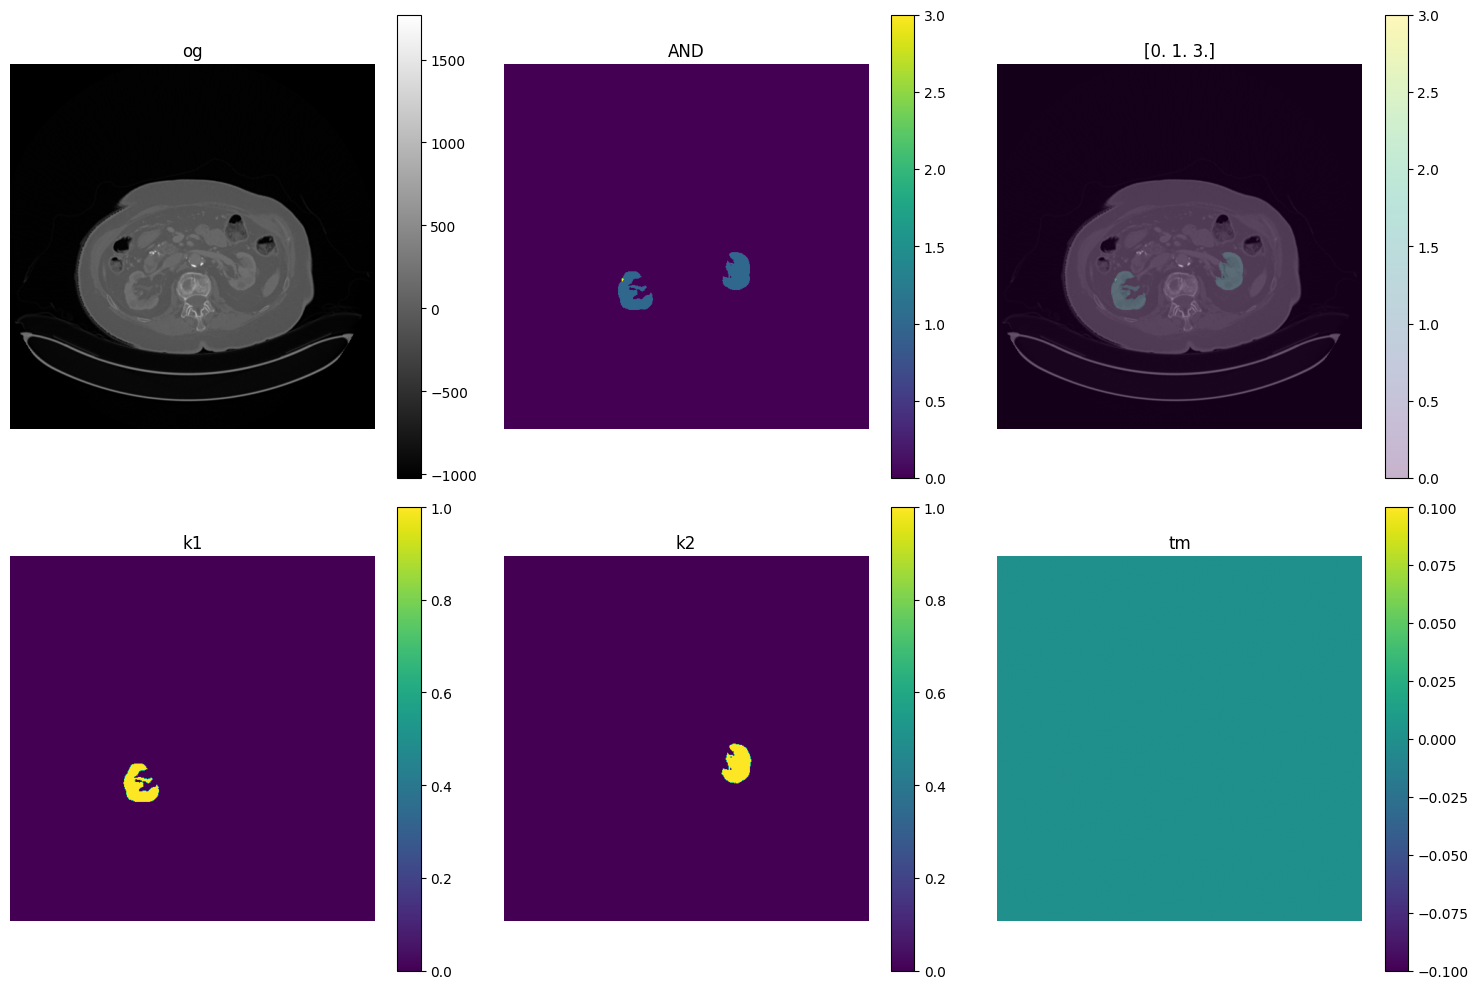

In [14]:
n_slice = np.random.choice(cy)
#n_slice = 65
print(n_slice)
plt.figure(figsize=(15,10))
plt.subplot(231)
plt.imshow(ct_[n_slice,:,:],cmap='gray')
plt.title('og')
plt.axis('off')
plt.colorbar()

plt.subplot(232)
plt.imshow(and_[n_slice,:,:])
plt.title(f'{np.unique(and_[n_slice,:,:])}')
plt.title('AND')
plt.axis('off')
plt.colorbar()

plt.subplot(233)
plt.imshow(ct_[n_slice,:,:],cmap='gray')
plt.imshow(and_[n_slice,:,:],alpha=0.3)
plt.title(f'{np.unique(and_[n_slice,:,:])}')
plt.axis('off')
plt.colorbar()
plt.subplot(234)
plt.imshow(k1_[n_slice,:,:])
plt.title('k1')
plt.axis('off')
plt.colorbar()
plt.subplot(235)
plt.imshow(k2_[n_slice,:,:])
plt.title('k2')
plt.axis('off')
plt.colorbar()

plt.subplot(236)
plt.imshow(tm_[n_slice,:,:])
plt.title('tm')
plt.axis('off')
plt.colorbar()

plt.savefig("images_database.png")
plt.tight_layout()

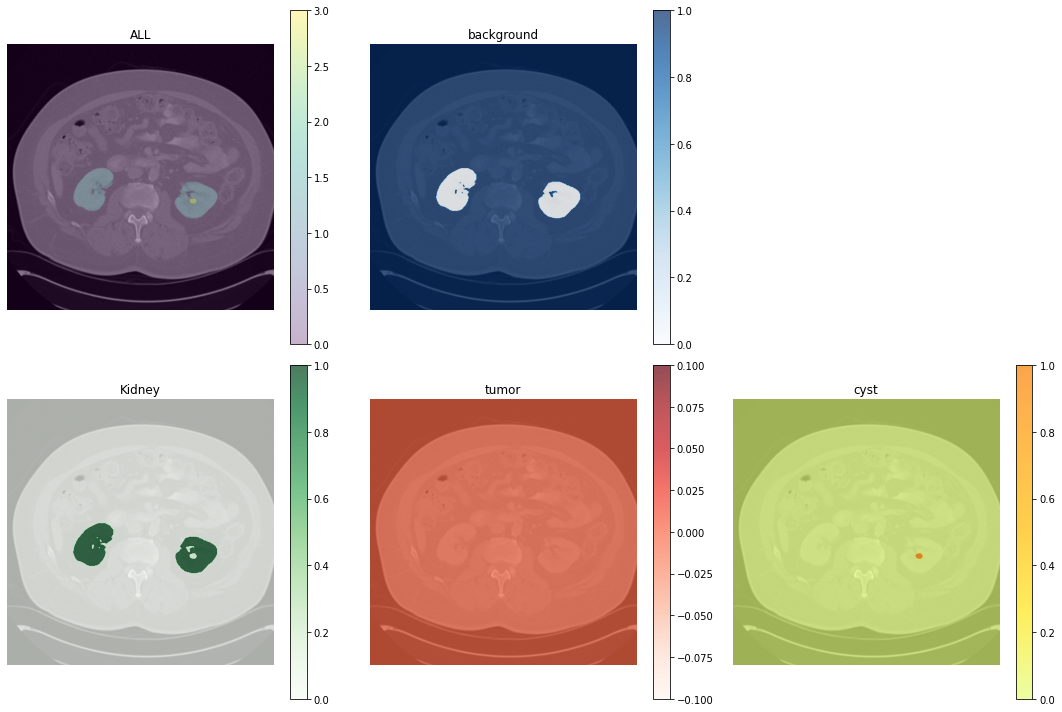

In [ ]:
plt.figure(figsize=(15,10))
plt.subplot(231)
plt.imshow(ct_[n_slice,:,:],cmap='gray')
plt.imshow(and_[n_slice,:,:],alpha=0.3)
plt.title('ALL')
plt.axis('off')
plt.colorbar()

plt.subplot(232)
background = and_[n_slice,:,:]== 0
plt.imshow(ct_[n_slice,:,:],cmap='gray')
plt.imshow(background,alpha=0.7,cmap='Blues')
plt.title('background')
plt.axis('off')
plt.colorbar()

plt.subplot(234)
Kidney = and_[n_slice,:,:]== 1
plt.imshow(ct_[n_slice,:,:],cmap='gray')
plt.imshow(Kidney,alpha=0.7,cmap='Greens')
plt.title('Kidney')
plt.axis('off')
plt.colorbar()

plt.subplot(235)
tumor = and_[n_slice,:,:]== 2
plt.imshow(ct_[n_slice,:,:],cmap='gray')
plt.imshow(tumor,alpha=0.7,cmap='Reds')
plt.title('tumor')
plt.axis('off')
plt.colorbar()

plt.subplot(236)
cyst = and_[n_slice,:,:]== 3
plt.imshow(ct_[n_slice,:,:],cmap='gray')
plt.imshow(cyst,alpha=0.7,cmap='Wistia')
plt.title('cyst')
plt.axis('off')
plt.colorbar()

plt.savefig("database images.png")
plt.tight_layout()


# Residual U-net architecture for segmentation

In [ ]:
%cd /content/kits21_spatial_channel_attention
from SCUnet import UNet as SCUnet

/content/kits21_spatial_channel_attention


In [ ]:
!rm '/content/kits19/kits.json'

In [ ]:
root_dir = '/content/resunet_checkpoints'
root_data='/content/kits19'

dir=sorted(os.listdir(root_data))
dir.remove('.ipynb_checkpoints')

train_images=[]
train_labels=[]
#the following save the direction for the images raw and the labels in this case AND state
for case in list(dir):
  train_images.append(root_data+"/"+case+"/imaging.nii.gz"),
  train_labels.append(root_data+"/"+case+"/aggregated_AND_seg.nii.gz")

  #make a dictionary separating each image with their respective label
data_dicts = [
        {"image": image_name, "label": label_name}
        for image_name, label_name in zip(train_images, train_labels)
    ]
print(len(data_dicts))

300


300

In [ ]:
#lets separate in training and validation all the images
train_files, val_files = data_dicts[90:], data_dicts[:90]  #separation depends on dicts length
#train_files, val_files = data_dicts[4:], data_dicts[:4]  #separation depends on dicts length for 2gb folder
print("VAL FILES = ", len(val_files), flush=True)
print("TRAIN FILES = ", len(train_files), flush=True)
print("MEMORY = ", str(round(psutil.virtual_memory().total / (1024.0 **3)))+" GB", flush=True)


VAL FILES =  90
TRAIN FILES =  210
MEMORY =  25 GB


In [ ]:
test_files = data_dicts[100:145]
print("TESTING FILES = ", len(test_files), flush=True)

TESTING FILES =  45


In [ ]:
from typing import Sized
import nibabel as nib
sizedh = []
for i in train_images:
    image = nib.load(i)
    image_data = image.get_fdata()
    sizedh.append(image_data.shape)

In [ ]:
#sizedh[105:150]

### Pre-processing

In [ ]:
#the following perform image processing and data augmentation on training dataset
train_transforms = Compose(
    [
        LoadImaged(keys=['image','label']),
        EnsureChannelFirstd(keys=["image", "label"]),
        Spacingd(keys=["image", "label"], pixdim=(
            2, 1.62, 1.62), mode=("bilinear", "nearest")),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        ScaleIntensityRanged(
            keys=["image"], a_min=-80, a_max=305,
            b_min=0.0, b_max=1.0, clip=True,
            ),
            CropForegroundd(keys=["image", "label"], source_key="image"),
            RandCropByPosNegLabeld(
                keys=["image", "label"],
                label_key="label",
                spatial_size=(160, 160, 64),
                pos=1,
                neg=1,
                num_samples=4,
                image_key="image",
                image_threshold=0,
            ),
             Rand3DElasticd(
                keys=["image", "label"],
                mode=("bilinear", "nearest"),
                prob=0.5,
                sigma_range=(5, 8),
                magnitude_range=(50, 150),
                spatial_size=(160, 160, 64),
                translate_range=(10, 10, 5),
                rotate_range=(np.pi/36,np.pi/36, np.pi),
                scale_range=(0.1, 0.1, 0.1),
                padding_mode="zeros",
            ),
            RandShiftIntensityd(
                keys=["image"],
                offsets=0.10,
                prob=0.25,
            ),
            RandGaussianNoised(keys=["image"], prob=0.25, mean=0.0, std=0.1),
            EnsureTyped(keys=["image", "label"]),
    ]
)

In [ ]:
test_transforms = Compose(
        [
            LoadImaged(keys=["image", "label"]),
            EnsureChannelFirstd(keys=["image", "label"]),
            Spacingd(keys=["image", "label"], pixdim=(
                2, 1.62, 1.62), mode=("bilinear", "nearest")),
            Orientationd(keys=["image", "label"], axcodes="RAS"),
            ScaleIntensityRanged(
                keys=["image"],a_min=-80, a_max=305,
                b_min=0.0, b_max=1.0, clip=True,
            ),
            CropForegroundd(keys=["image", "label"], source_key="image"),
         RandCropByPosNegLabeld(
                keys=["image", "label"],
                label_key="label",
                spatial_size=(150, 150, 64),
                pos=1,
                neg=1,
                num_samples=4,
                image_key="image",
                image_threshold=0,
            ),
            EnsureTyped(keys=["image", "label"]),
        ]
    )

print("CREATING TRAIN DS", flush=True)

CREATING TRAIN DS


In [ ]:
val_transforms = Compose(
        [
            LoadImaged(keys=["image", "label"]),
            EnsureChannelFirstd(keys=["image", "label"]),
            Spacingd(keys=["image", "label"], pixdim=(
                2, 1.62, 1.62), mode=("bilinear", "nearest")),
            Orientationd(keys=["image", "label"], axcodes="RAS"),
            ScaleIntensityRanged(
                keys=["image"],a_min=-80, a_max=305,
                b_min=0.0, b_max=1.0, clip=True,
            ),
            CropForegroundd(keys=["image", "label"], source_key="image"),
            EnsureTyped(keys=["image", "label"]),
        ]
    )

In [ ]:
### USE THIS CODE WITH THE WHOLE DATASET 

train_ds = SmartCacheDataset(data=train_files, transform=train_transforms,cache_rate=0.1, replace_rate=0.5)
print(len(train_ds))
print("CREATED TRAIN DS", flush=True)

train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=0)
print("CREATED TRAIN DATALOADER", flush=True) 


Loading dataset: 100%|██████████| 21/21 [02:24<00:00,  6.89s/it]

21
CREATED TRAIN DS
CREATED TRAIN DATALOADER


In [ ]:
## USE THE FOLLOWING WITH THE WHOLE DATASET

val_ds = SmartCacheDataset(data=val_files, transform=val_transforms, cache_rate=0.1,replace_rate=0.5)
print("CREATED VAL DS", flush=True)

val_loader = DataLoader(val_ds, batch_size=1, num_workers=0)
print("CREATED VAL DATALOADER", flush=True)

Loading dataset: 100%|██████████| 9/9 [00:49<00:00,  5.45s/it]

CREATED VAL DS
CREATED VAL DATALOADER


In [ ]:
from monai.data import pad_list_data_collate
## USE THE FOLLOWING WITH THE WHOLE DATASET

test_ds = SmartCacheDataset(data=test_files, transform=test_transforms, cache_rate=0.1,replace_rate=0.5)
print("CREATED TEST DS", flush=True)

test_loader = DataLoader(test_ds, batch_size=1, num_workers=0)
print("CREATED TEST DATALOADER", flush=True)

Loading dataset: 100%|██████████| 4/4 [00:13<00:00,  3.28s/it]

CREATED TEST DS
CREATED TEST DATALOADER


In [ ]:
#model = SCUNet(
#        dimensions=3,
#        in_channels=1,
#        out_channels=4,
#        channels=(64, 128, 256, 512, 512),
#        strides=(2, 2, 2, 2), 
#    )

## Model definition and training

In [ ]:
#PYTORCH_CUDA_ALLOC_CONF = "0.99"
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
#Residual Unet for comparision
model = UNet(
  dimensions=3,
  in_channels=1,
  out_channels=4,
  channels=(64, 128, 256, 512),
  strides=(2, 2, 2, 2),
  num_res_units=2,
  norm="INSTANCE",
).to(device)

/usr/local/lib/python3.8/dist-packages/monai/utils/deprecate_utils.py:219: FutureWarning: monai.networks.nets.unet UNet.__init__:dimensions: Argument `dimensions` has been deprecated since version 0.6. Please use `spatial_dims` instead.
  warn_deprecated(argname, msg, warning_category)
/usr/local/lib/python3.8/dist-packages/monai/networks/nets/unet.py:139: UserWarning: `len(strides) > len(channels) - 1`, the last 1 values of strides will not be used.
  warnings.warn(f"`len(strides) > len(channels) - 1`, the last {delta} values of strides will not be used.")


In [ ]:
model.load_state_dict(torch.load(best_metric_model_file, map_location=torch.device(device)))

<All keys matched successfully>

In [ ]:
max_epochs = 60
val_interval = 1
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
learning_rate = 0.0001

post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=4)])
post_label = Compose([EnsureType(), AsDiscrete(to_onehot=4)])

In [ ]:
##Parts of the model loss function, optimizer, dicemetric
print("CREATED MODEL", flush=True)

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.AdamW(model.parameters(), learning_rate)
dice_metric = DiceMetric(include_background=False, reduction="mean")

CREATED MODEL


In [ ]:
#TRAINING LOOP FOR THE NN
for epoch in range(max_epochs):
  print("-" * 10, flush=True)
  print(f"epoch {epoch + 1}/{max_epochs}", flush=True)
  model.train()
  epoch_loss = 0
  step = 0
  for batch_data in train_loader:
    step += 1
    inputs, labels = (
          batch_data["image"].to(device),
          batch_data["label"].to(device),
        )
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = loss_function(outputs, labels)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
    print(
              f"{step}/{len(train_ds) // train_loader.batch_size}, "
              f"train_loss: {loss.item():.4f}", flush=True)
  epoch_loss /= step
  epoch_loss_values.append(epoch_loss)
  print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}", flush=True)

  if (epoch + 1) % val_interval == 0:
    model.eval()
    with torch.no_grad():
      for val_data in val_loader:
        val_inputs, val_labels = (
        val_data["image"].to(device),
        val_data["label"].to(device),
        )
        roi_size = (160,160, 64)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(
        val_inputs, roi_size, sw_batch_size, model)
        val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
        val_labels = [post_label(i) for i in decollate_batch(val_labels)]
        # compute metric for current iteration
        dice_metric(y_pred=val_outputs, y=val_labels)

      # aggregate the final mean dice result
      metric = dice_metric.aggregate().item()
      # reset the status for next validation round
      dice_metric.reset()

      metric_values.append(metric)
      if metric > best_metric:
        best_metric = metric
        best_metric_epoch = epoch + 1
        torch.save(model.state_dict(), os.path.join(
            root_dir, "best_metric_model_"+str(epoch)+"_"+str(f"{metric:.4f}")+".pth"))
        print("saved new best metric model", flush=True)
      print(
          f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
          f"\nbest mean dice: {best_metric:.4f} "
          f"at epoch: {best_metric_epoch}", flush=True
          )


----------
epoch 1/60
1/10, train_loss: 0.4090
2/10, train_loss: 0.2947
3/10, train_loss: 0.4485
4/10, train_loss: 0.3499
5/10, train_loss: 0.3608
6/10, train_loss: 0.3891
7/10, train_loss: 0.2950
8/10, train_loss: 0.5423
9/10, train_loss: 0.3531
10/10, train_loss: 0.3160
11/10, train_loss: 0.4110
epoch 1 average loss: 0.3790
saved new best metric model
current epoch: 1 current mean dice: 0.6476
best mean dice: 0.6476 at epoch: 1
----------
epoch 2/60
1/10, train_loss: 0.4034
2/10, train_loss: 0.4034
3/10, train_loss: 0.4488
4/10, train_loss: 0.3249
5/10, train_loss: 0.3737
6/10, train_loss: 0.5111
7/10, train_loss: 0.3121
8/10, train_loss: 0.6684
9/10, train_loss: 0.4019
10/10, train_loss: 0.3876
11/10, train_loss: 0.3242
epoch 2 average loss: 0.4145
saved new best metric model
current epoch: 2 current mean dice: 0.6560
best mean dice: 0.6560 at epoch: 2
----------
epoch 3/60
1/10, train_loss: 0.4667
2/10, train_loss: 0.3638
3/10, train_loss: 0.3334
4/10, train_loss: 0.4265
5/10, trai

In [ ]:
!zip -r checkpoints.zip /content/resunet_checkpoints  #to save configurations with best metrics

  adding: content/resunet_checkpoints/ (stored 0%)
  adding: content/resunet_checkpoints/best_metric_model_16_0.6647.pth (deflated 7%)
  adding: content/resunet_checkpoints/best_metric_model_17_0.6683.pth (deflated 7%)
  adding: content/resunet_checkpoints/best_metric_model_8_0.6604.pth (deflated 7%)
  adding: content/resunet_checkpoints/best_metric_model_0_0.6263.pth (deflated 7%)
  adding: content/resunet_checkpoints/best_metric_model_2_0.6391.pth (deflated 7%)
  adding: content/resunet_checkpoints/best_metric_model_14_0.6646.pth (deflated 7%)
  adding: content/resunet_checkpoints/best_metric_model_13_0.6626.pth (deflated 7%)
  adding: content/resunet_checkpoints/best_metric_model_7_0.6598.pth (deflated 7%)


## Model Evaluation

In [ ]:
dice_val = metric_values
loss_val = epoch_loss_values

acc = dice_val
#val_acc = model.model['val_acc']
loss = loss_val
#val_loss = model.model['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training acc')
#plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Dice matric')
plt.ylabel('dice')  
plt.xlabel('epoch')
plt.legend()
plt.figure()

# Mostrar la figura
plt.savefig("dice_epoch.png")
plt.show()


plt.plot(epochs, loss, 'r', label='Training loss')
#plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('loss')
plt.ylabel('loss')  
plt.xlabel('epoch')
plt.legend()
plt.show()

# Mostrar la figura
plt.savefig("loss_ecpoch.png")
plt.show()

In [ ]:
from monai.metrics import DiceMetric
dice_metric = DiceMetric(include_background=False, reduction="mean")

model.eval()
pred_labels = []
true_labels = []
dice_values = []  # lista para guardar los coeficientes DICE de cada imagen
with torch.no_grad():
    for val_data in test_loader:
        val_inputs, val_labels = val_data["image"].to(device), val_data["label"].to(device)
        roi_size = (160,160, 64)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
        val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
        val_labels = [post_label(i) for i in decollate_batch(val_labels)]
        # append predicted labels and true labels for each image
        for i in range(val_inputs.shape[0]):
            pred_labels.append(val_outputs[i])
            true_labels.append(val_labels[i])
            # calculate DICE coefficient for current image
            dice_value = dice_metric(y_pred=val_outputs, y=val_labels)
            dice_values.append(dice_value)

# compute the mean DICE coefficient for all images
mean_dice = dice_metric.aggregate().item()

dice_metric.reset()

print('DICE coefficients for Testing images:')
print(dice_values)
print('Mean DICE coefficient:', mean_dice)


DICE coefficients for Testing images:
[tensor([[0.9223, 0.8142, 0.0000],
        [0.9175, 0.8518, 0.0000],
        [0.9164, 0.7929, 0.0000],
        [0.9223, 0.8142, 0.0000]], device='cuda:0'), tensor([[0.9223, 0.8142, 0.0000],
        [0.9175, 0.8518, 0.0000],
        [0.9164, 0.7929, 0.0000],
        [0.9223, 0.8142, 0.0000]], device='cuda:0'), tensor([[0.9223, 0.8142, 0.0000],
        [0.9175, 0.8518, 0.0000],
        [0.9164, 0.7929, 0.0000],
        [0.9223, 0.8142, 0.0000]], device='cuda:0'), tensor([[0.9223, 0.8142, 0.0000],
        [0.9175, 0.8518, 0.0000],
        [0.9164, 0.7929, 0.0000],
        [0.9223, 0.8142, 0.0000]], device='cuda:0'), tensor([[0.9384, 0.0000, 0.0787],
        [0.9398, 0.0000, 0.0348],
        [0.9322,    nan, 0.1193],
        [0.9458, 0.0000, 0.0000]], device='cuda:0'), tensor([[0.9384, 0.0000, 0.0787],
        [0.9398, 0.0000, 0.0348],
        [0.9322,    nan, 0.1193],
        [0.9458, 0.0000, 0.0000]], device='cuda:0'), tensor([[0.9384, 0.0000, 0.0787

In [ ]:
model.eval()
pred_labels = []
true_labels = []
dice_values = []
with torch.no_grad():
    for val_data in test_loader:
        val_inputs, val_labels = val_data["image"].to(device), val_data["label"].to(device)
        roi_size = (160,160, 64)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
        val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
        val_labels = [post_label(i) for i in decollate_batch(val_labels)]
        # append predicted labels and true labels for each image
        for i in range(val_inputs.shape[0]):
            pred_labels.append(val_outputs[i])
            true_labels.append(val_labels[i])
        # compute metric for current iteration
        dice_value = dice_metric(y_pred=val_outputs, y=val_labels)
        dice_values.append(dice_value)
# aggregate the final mean dice result
metric1 = dice_metric.aggregate().item()

dice_metric.reset()

metric_values.append(metric)
print('Dice coeficcient for Testing images')
print(metric1)


In [ ]:
from sklearn.metrics import jaccard_score


# convert arrays to numpy arrays
pred_labels = np.concatenate(pred_labels)
true_labels = np.concatenate(true_labels)

# compute confusion matrix
jaccard_coefficient = jaccard_score(true_labels.flatten(), pred_labels.flatten())

# print confusion matrix
print("El coeficiente de Jaccard es:", jaccard_coefficient)

El coeficiente de Jaccard es: 0.9933144372200254


# Visualization of results

In [ ]:
pred_labels = np.concatenate(pred_labels)
true_labels = np.concatenate(true_labels)


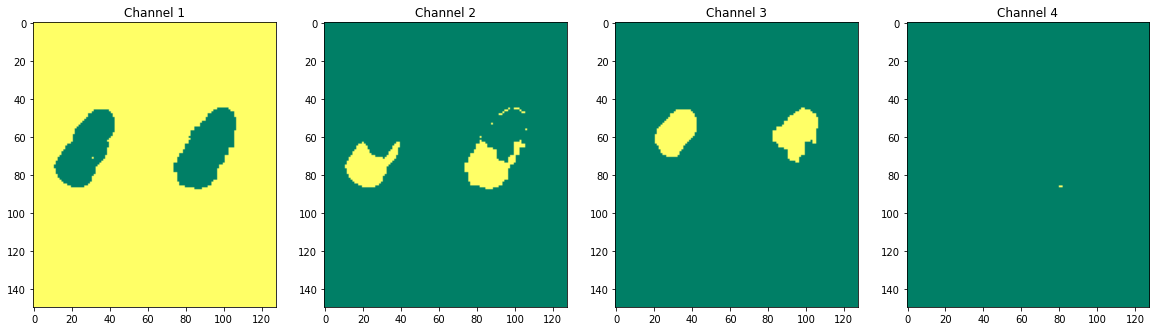

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# assuming pred_labels and true_labels have shape (4, 257, 225, 266)

# select a random slice to display
slice_index = 115


# create a figure with subplots for each channel
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 8))

# display each channel in a separate subplot
for channel in range(4):
    # get the slice for the current channel
    pred_slice = pred_labels[channel, slice_index, :, :]
    true_slice = true_labels[channel, slice_index, :, :]
    
    # display the slice
    axs[channel].imshow(np.concatenate((pred_slice, true_slice), axis=1), cmap='summer')
    axs[channel].set_title(f'Channel {channel+1}')


# set the title for the entire figure
#fig.title(f'Prediction vs. True Labels (Slice {slice_index})')

#fig.suptitle(f'Prediction vs. True Labels (Slice {slice_index})')

# show the figure
plt.savefig("prediction.png")
plt.show()


In [ ]:
for j,i in tqdm(enumerate(pred_labels)):
    if np.unique(i).max() == 3.0:
        cy.append(j)
len(cy)

64it [00:02, 31.62it/s]


16

1


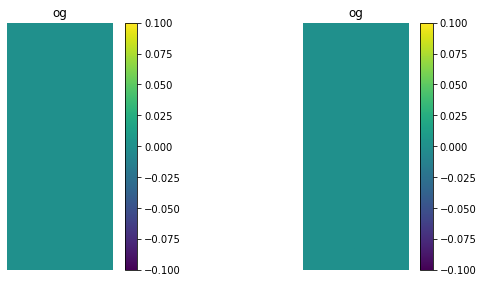

In [ ]:
n_slice = 1

print(n_slice)
plt.figure(figsize=(15,10))
plt.subplot(231)
plt.imshow(pred_labels[3,n_slice,:,:])
plt.title('og')
plt.axis('off')
plt.colorbar()

plt.subplot(232)
plt.imshow(true_labels[3,n_slice,:,:])
plt.title('og')
plt.axis('off')
plt.colorbar()


In [ ]:
#to move around several slices

#n_slice = np.random.choice(cy)
for i in range(125):
  plt.figure(figsize=(15,10))
  plt.subplot(231)
  plt.imshow(pred_labels[2,i,:,:])
  plt.colorbar()

  plt.subplot(232)
  plt.imshow(true_labels[2,i,:,:])
  plt.colorbar()

  plt.subplot(233)
  plt.imshow(pred_labels[3,i,:,:])
  plt.colorbar()

  plt.subplot(233)
  plt.imshow(true_labels[3,i,:,:])
  plt.colorbar()